#### Inference: 
This notebook 0.857  

Version 2

model:
/kaggle/input/sn-hoa-8e-5-27-rot0-5/se_resnext50_32x4d_26_loss0.10_score0.90_val_loss0.12_val_score0.88_midd_1024.pt.  From dataset «sn-hoa-8e-5-27-rot0-5» Version 1 name of version "Version 1 - Initial release"

idia 0:        
         th_percentile = 0.00149                            (-> 0.857)


# Train: 
https://www.kaggle.com/nguynvnthtr/the-training-image-is-1024-x-1024  

version 1

idia  : image_size = 1024

idia 1:

        x_index= (x.shape[1]-self.image_size)//2 
        
        y_index= (x.shape[2]-self.image_size)//2   (-> 0.628)
        
idia 2:
     
        p_augm = 0.05  #probability of augmentaton changed to 0.05    (-> 0.686)
        

    
idia 3:

        in_chans = 1  #window for moov label changed to 1    (-> 0.800)
        
idia 4:
 
        Epoch = 27                                           (-> 0.856)


idia 5:

        lr = 8e-5

# All get from:

**This code is base on [2.5d segmentaion baseline [inference]](https://www.kaggle.com/code/tanakar/2-5d-segmentaion-baseline-inference)**
If you think my code is useful,please upvote it ^w^.
* Version2:
1. *     updata normalization method
2. *     image_size = 512
3. *     useing 3d TTA
4. *     se_resnext50_32x4d

* Version3:
1. *     updata normalization method

* This version is correspond with [2.5d segmentaion baseline [training]](https://www.kaggle.com/code/yoyobar/2-5d-cutting-model-baseline-training) version6


In [ ]:
pip install pandas

# Import

In [3]:
import torch as tc 
import torch.nn as nn  
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import autocast
import cv2
import os,sys
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
#!python -m pip install --no-index --find-links=/kaggle/input/pip-download-for-segmentation-models-pytorch segmentation-models-pytorch
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel
from dotenv import load_dotenv


ModuleNotFoundError: No module named 'pandas'

# config

In [2]:
model_path_i = 13     # 12 #9 # 7 #5 #in_chans_1__25     3 in_chans_1__20 2 
#model_path_i9 = 12  # 9 #11


class CFG:
# ============== model CFG =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'

    in_chans = 1 #5 # 65
    #============== _ CFG =============
    image_size = 1024 #512
    input_size= 1024 #512
    tile_size = image_size
    stride = tile_size // 4
    drop_egde_pixel= 0 # 16 #32
    
    target_size = 1
    chopping_percentile=1e-3
    # ============== fold =============
    valid_id = 1
    batch=16 #128

    th_percentile_i = 3
    th_percentile_list = [0.0013099, 0.0013499, 0.0013999, 0.0014499,   0.0014999 ]

    th_percentile = th_percentile_list[th_percentile_i] #0.00143 #0.00145 #0.00146 #0.00149 #0.00145 # 0.0014 #0.00175 #0.0021
    
    #axis_w = [0.3353333 ,0.3323333,0.3323333 ]
    model_path=["/kaggle/input/2-5d-cutting-model-baseline-training/se_resnext50_32x4d_19_loss0.12_score0.79_val_loss0.25_val_score0.79.pt",
               "/kaggle/input/training-6-512/se_resnext50_32x4d_19_loss0.09_score0.83_val_loss0.28_val_score0.83.pt",
               "/kaggle/input/training-6-512/se_resnext50_32x4d_19_loss0.05_score0.90_val_loss0.25_val_score0.86.pt",
               "/kaggle/input/training-6-512/se_resnext50_32x4d_19_loss0.05_score0.89_val_loss0.24_val_score0.86_midd.pt",
               "/kaggle/input/training-6-512/se_resnext50_32x4d_24_loss0.05_score0.90_val_loss0.23_val_score0.88_midd.pt",
               "/kaggle/input/training-6-512/se_resnext50_32x4d_24_loss0.04_score0.91_val_loss0.23_val_score0.88_midd.pt", # 25 025 rot 512 center
               "/kaggle/input/blood-vessel-model-1024/se_resnext50_32x4d_24_loss0.10_score0.90_val_loss0.16_val_score0.85_midd_1024.pt",
               "/kaggle/input/blood-vessel-model-1024/se_resnext50_32x4d_24_loss0.10_score0.90_val_loss0.12_val_score0.88_midd_1024.pt",# lr = 8e-5
               "/kaggle/input/blood-vessel-model-1024/se_resnext50_32x4d_24_loss0.91_score0.09_val_loss0.91_val_score0.09_midd_1024.pt", #  60e-5 
               "/kaggle/input/sn-hoa-8e-5-27-rot0-5/se_resnext50_32x4d_26_loss0.10_score0.90_val_loss0.12_val_score0.88_midd_1024.pt",#8e-5-27-rot0-5
               "/kaggle/input/sn-hoa-8e-5-27-rot0-5/se_resnext50_32x4d_30_loss0.10_score0.90_val_loss0.13_val_score0.88_midd_1024.pt",
               "/kaggle/input/sennet-kidney-1-and-3/model_real_23.pt",
               "/kaggle/input/sn-hoa-8e-5-27-rot0-5/se_resnext50_32x4d_26_loss0.15_score0.85_val_loss0.24_val_score0.77_midd_1024.pt",
               "/kaggle/input/sn-hoa-8e-5-27-rot0-5/se_resnext50_32x4d_24_loss0.15_score0.85_val_loss0.21_val_score0.80_midd_1024.pt"]#  31 8e 05  

# Model

In [3]:
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None ):
        super().__init__()
        self.CFG = CFG
        
        
        
        
        self.model = smp.FPN( #Unet
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )
        self.batch=CFG.batch

    def forward_(self, image):
        output = self.model(image)
        return output[:,0]
    
    def forward(self,x:tc.Tensor):
        #x.shape=(batch,c,h,w)
        x=x.to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x,size=(CFG.input_size,CFG.input_size),mode='bilinear',align_corners=True)
        
        shape=x.shape
        x=[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(4)]
        x=tc.cat(x,dim=0)
        with autocast():
            with tc.no_grad():
                x=[self.forward_(x[i*self.batch:(i+1)*self.batch]) for i in range(x.shape[0]//self.batch+1)]
                # batch=64,64...48
                x=tc.cat(x,dim=0)
        x=x.sigmoid()
        x=x.reshape(4,shape[0],*shape[2:])
        x=[tc.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
        x=tc.stack(x,dim=0).mean(0)
        
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x[None],size=(CFG.image_size,CFG.image_size),mode='bilinear',align_corners=True)[0]
        return x


def build_model(weight=None ):
    load_dotenv()

    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    model = CustomModel(CFG, weight  )

    return model.cuda()

# Size

In [4]:
def to_1024(img , image_size = 1024):
    if image_size > img.shape[1]:
       img = np.rot90(img)
       start1 = (CFG.image_size - img.shape[0])//2 
       top =     img[0                    : start1,   0: img.shape[1] ]
       bottom  = img[img.shape[0] -start1 : img.shape[0],   0 : img.shape[1] ]
       img_result = np.concatenate((top,img,bottom ),axis=0)
       img_result = np.rot90(img_result)
       img_result = np.rot90(img_result)
       img_result = np.rot90(img_result)
    else :
       img_result = img
    return img_result

def to_1024_no_rot(img, image_size = 1024):
    if image_size > img.shape[0]:  
       start1 = ( image_size - img.shape[0])//2
       top =     img[0                    : start1,   0: img.shape[1] ]
       bottom  = img[img.shape[0] -start1 : img.shape[0],   0 : img.shape[1] ]
       img_result = np.concatenate((top,img,bottom ),axis=0)
    else: 
       img_result = img
    return img_result

def to_1024_1024(img  , image_size = 1024 ):
     img_result = to_1024(img, image_size )
     return img_result
    
def to_original ( im_after, img, image_size = 1024 ):
    top_ = 0
    left_ = 0
    if (im_after.shape[0] > img.shape[0]):
             top_  = ( image_size - img.shape[0])//2 
    if    (im_after.shape[1] > img.shape[1]) :
             left_  = ( image_size - img.shape[1])//2  
    if (top_>0)or (left_>0) :
             img_result = im_after[top_  : img.shape[0] + top_,   left_: img.shape[1] + left_ ]
    else:
             img_result = im_after
    return img_result  

# Functions

In [5]:
def rle_encode(mask):
    pixel = mask.flatten()
    pixel = np.concatenate([[0], pixel, [0]])
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1
    run[1::2] -= run[::2]
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 0'
    return rle

def min_max_normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,...)"""
    shape=x.shape
    if x.ndim>2:
        x=x.reshape(x.shape[0],-1)
    
    min_=x.min(dim=-1,keepdim=True)[0]
    max_=x.max(dim=-1,keepdim=True)[0]
    if min_.mean()==0 and max_.mean()==1:
        return x.reshape(shape)
    
    x=(x-min_)/(max_-min_+1e-9)
    return x.reshape(shape)

def norm_with_clip(x:tc.Tensor,smooth=1e-5):
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    x=(x-mean)/(std+smooth)
    x[x>5]=(x[x>5]-5)*1e-3 +5
    x[x<-3]=(x[x<-3]+3)*1e-3-3
    return x

class Data_loader(Dataset):
    def __init__(self,path,s="/images/"):
        self.paths=glob(path+f"{s}*.tif")
        self.paths.sort()
        self.bool=s=="/labels/"
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
        img=cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        img = to_1024_1024(img , image_size = CFG.image_size )
        
        img=tc.from_numpy(img.copy())
        if self.bool:
            img=img.to(tc.bool)
        else:
            img=img.to(tc.uint8)
        return img

def load_data(path,s):
    data_loader=Data_loader(path,s)
    data_loader=DataLoader(data_loader, batch_size=16, num_workers=2)
    data=[]
    for x in tqdm(data_loader):
        data.append(x)
    x=tc.cat(data,dim=0)
    ########################################################################
    TH=x.reshape(-1).numpy()
    index = -int(len(TH) * CFG.chopping_percentile)
    TH:int = np.partition(TH, index)[index]
    x[x>TH]=int(TH)
    ########################################################################
    TH=x.reshape(-1).numpy()
    index = -int(len(TH) * CFG.chopping_percentile)
    TH:int = np.partition(TH, -index)[-index]
    x[x<TH]=int(TH)
    ########################################################################
    #x=(min_max_normalization(x.to(tc.float16))*255).to(tc.uint8)
    return x

class Pipeline_Dataset(Dataset):
    def __init__(self,x,path):
        self.img_paths  = glob(path+"/images/*")
        self.img_paths.sort()
        self.in_chan = CFG.in_chans
        z=tc.zeros(self.in_chan//2,*x.shape[1:],dtype=x.dtype)
        self.x=tc.cat((z,x,z),dim=0)
        
    def __len__(self):
        return self.x.shape[0]-self.in_chan+1
    
    def __getitem__(self, index):
        x  = self.x[index:index+self.in_chan]
        return x,index
    
    def get_mark(self,index):
        id=self.img_paths[index].split("/")[-3:]
        id.pop(1)
        id="_".join(id)
        return id[:-4]
    
    def get_marks(self):
        ids=[]
        for index in range(len(self)):
            ids.append(self.get_mark(index))
        return ids

def add_edge(x:tc.Tensor,edge:int):
    #x=(C,H,W)
    #output=(C,H+2*edge,W+2*edge)
    mean_=int(x.to(tc.float32).mean())
    x=tc.cat([x,tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_],dim=1)
    x=tc.cat([x,tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_],dim=2)
    x=tc.cat([tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_,x],dim=1)
    x=tc.cat([tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_,x],dim=2)
    return x

# Build model(s)

In [6]:
model=build_model(   )
model.load_state_dict(tc.load(CFG.model_path[ model_path_i ],"cpu"))
model.eval()
model=DataParallel(model)

model_name Unet
backbone se_resnext50_32x4d


AssertionError: Torch not compiled with CUDA enabled

In [7]:
def get_output(debug=False):
    outputs=[]
    
    if debug:
        paths=["/kaggle/input/blood-vessel-segmentation/train/kidney_2"]
    else:
        paths=glob("/kaggle/input/blood-vessel-segmentation/test/*")
    outputs=[[],[]]
    for path in paths:
        x=load_data(path,"/images/")
        labels=tc.zeros_like(x,dtype=tc.uint8)
        mark=Pipeline_Dataset(x,path).get_marks()
        
        
        for axis in [0,1,2]:
            debug_count=0
            if axis==0:
                x_=x
                labels_=labels
            elif axis==1:
                x_=x.permute(1,2,0)
                labels_=labels.permute(1,2,0)
            elif axis==2:
                x_=x.permute(2,0,1)
                labels_=labels.permute(2,0,1)
            if x.shape[0]==3 and axis!=0:
                break
            dataset=Pipeline_Dataset(x_,path)
            dataloader=DataLoader(dataset,batch_size=1,shuffle=False,num_workers=1)
            shape=dataset.x.shape[-2:]
            x1_list = np.arange(0, shape[0]+CFG.tile_size-CFG.tile_size+1, CFG.stride)
            y1_list = np.arange(0, shape[1]+CFG.tile_size-CFG.tile_size+1, CFG.stride)
            for img,index in tqdm(dataloader):
                #img=(1,C,H,W)
                img=img.to("cuda:0")
                img=add_edge(img[0],CFG.tile_size//2)[None]

                mask_pred = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)
                mask_count = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)

                indexs=[]
                chip=[]
                for y1 in y1_list:
                    for x1 in x1_list:
                        x2 = x1 + CFG.tile_size
                        y2 = y1 + CFG.tile_size
                        indexs.append([x1+CFG.drop_egde_pixel,x2-CFG.drop_egde_pixel,
                                       y1+CFG.drop_egde_pixel,y2-CFG.drop_egde_pixel])
                        chip.append(img[...,x1:x2,y1:y2])

                y_preds = model.forward(tc.cat(chip)).to(device=0)
                
                
                if CFG.drop_egde_pixel:
                    y_preds=y_preds[...,CFG.drop_egde_pixel:-CFG.drop_egde_pixel,
                                        CFG.drop_egde_pixel:-CFG.drop_egde_pixel]
                for i,(x1,x2,y1,y2) in enumerate(indexs):
                    mask_pred[...,x1:x2, y1:y2] += y_preds[i]
                    mask_count[...,x1:x2, y1:y2] += 1

                mask_pred /= mask_count

                #Rrecover
                mask_pred=mask_pred[...,CFG.tile_size//2:-CFG.tile_size//2,CFG.tile_size//2:-CFG.tile_size//2]
                
                labels_[index]+=(mask_pred[0]*255 /3 ).to(tc.uint8).cpu()
                if debug:
                    debug_count+=1
                    plt.subplot(121)
                    plt.imshow(img[0,CFG.in_chans//2].cpu().detach().numpy())
                    plt.subplot(122)
                    plt.imshow(mask_pred[0].cpu().detach().numpy())
                    plt.show()
                    if debug_count>3:
                        break
        outputs[0].append(labels)
        outputs[1].extend(mark)
    return outputs

  0%|          | 0/2217 [00:00<?, ?it/s]

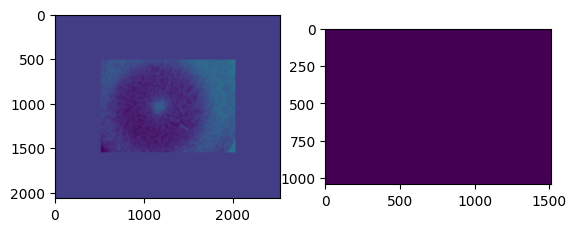

  0%|          | 1/2217 [00:05<3:07:59,  5.09s/it]

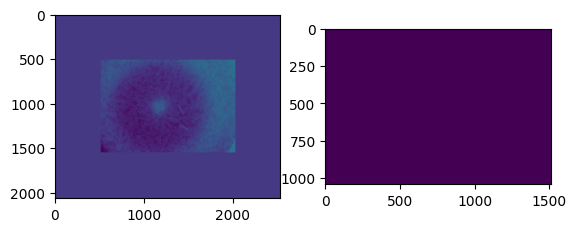

  0%|          | 2/2217 [00:08<2:25:19,  3.94s/it]

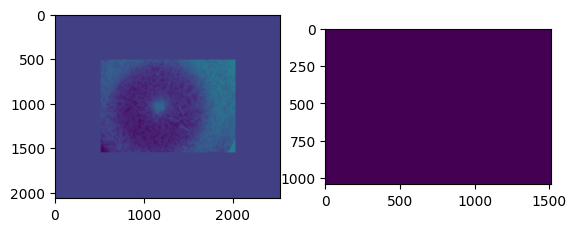

  0%|          | 3/2217 [00:11<2:12:10,  3.58s/it]

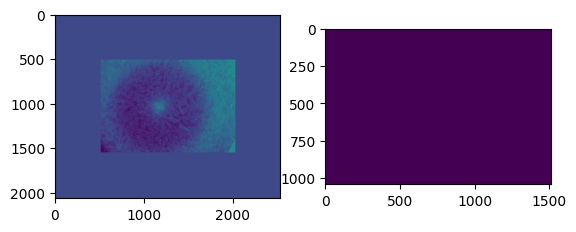

  0%|          | 0/1041 [00:00<?, ?it/s]

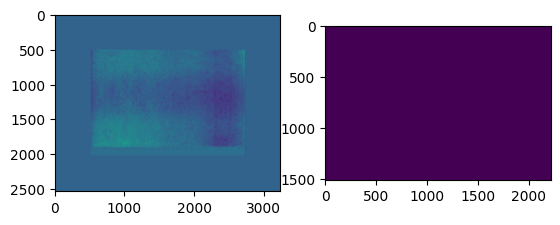

  0%|          | 1/1041 [00:05<1:37:36,  5.63s/it]

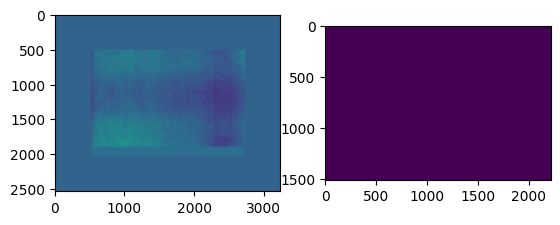

  0%|          | 2/1041 [00:11<1:35:33,  5.52s/it]

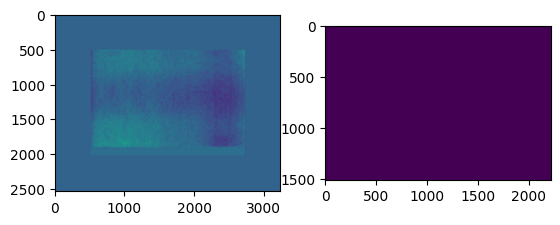

  0%|          | 3/1041 [00:16<1:34:48,  5.48s/it]

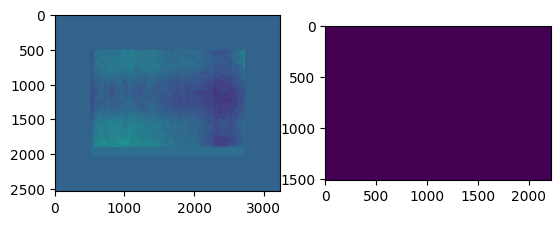

  0%|          | 0/1511 [00:00<?, ?it/s]

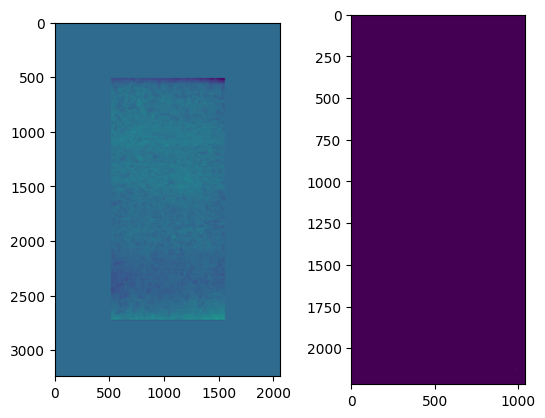

  0%|          | 1/1511 [00:08<3:29:48,  8.34s/it]

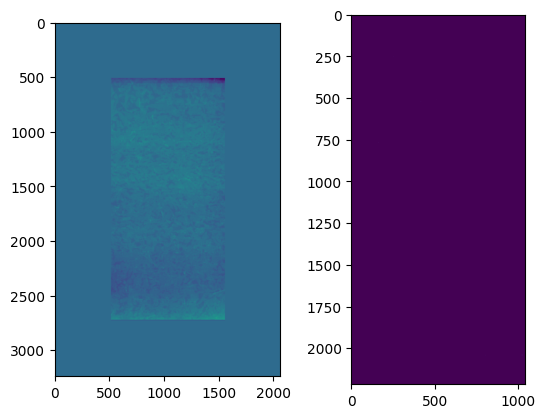

  0%|          | 2/1511 [00:13<2:37:14,  6.25s/it]

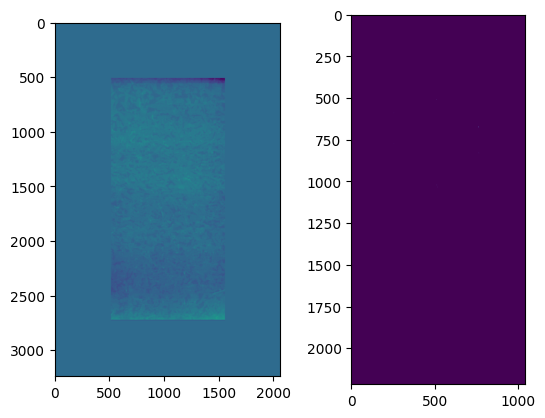

  0%|          | 3/1511 [00:17<2:19:06,  5.53s/it]

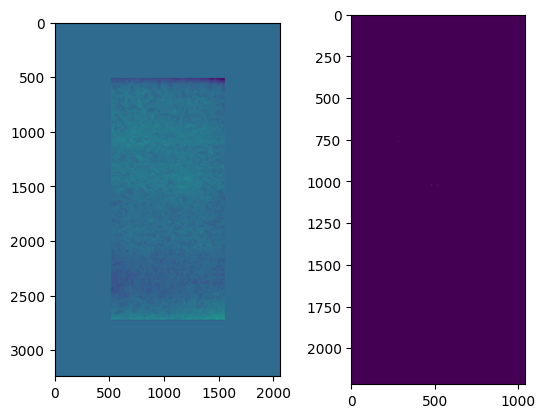

  0%|          | 3/1511 [00:22<3:11:19,  7.61s/it]


0


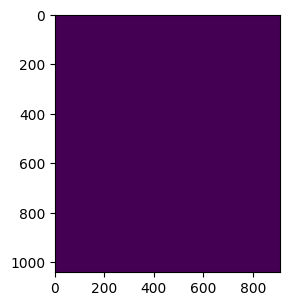

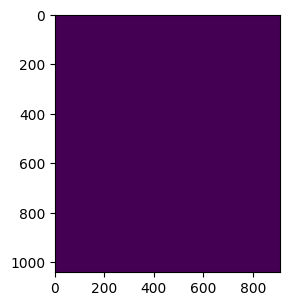

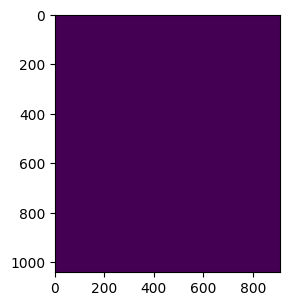

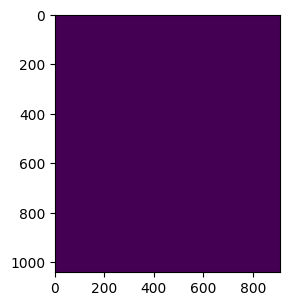

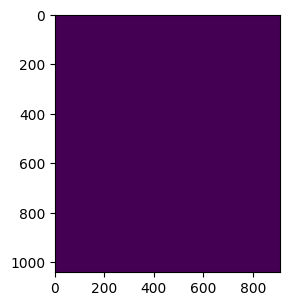

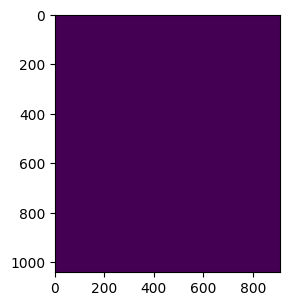

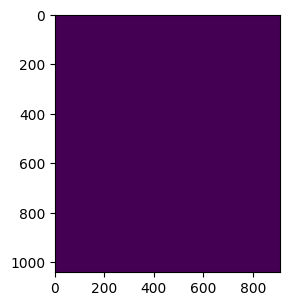

,id,rle
0,kidney_2_0000,1 0
0,kidney_2_0001,1 0
0,kidney_2_0002,1 0
0,kidney_2_0003,1 0
0,kidney_2_0004,1 0
0,kidney_2_0005,1 0


In [8]:
is_submit=len(glob("/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/*.tif"))!=3
#is_submit=True
output,ids=get_output(not is_submit)


####################################
TH=[x.flatten().numpy() for x in output]
TH=np.concatenate(TH)
index = -int(len(TH) * CFG.th_percentile)
TH:int = np.partition(TH, index)[index]
print(TH)

img=cv2.imread("/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/0001.tif",cv2.IMREAD_GRAYSCALE)

####################################
submission_df=[]
debug_count=0
for index in range(len(ids)):
    id=ids[index]
    i=0
    for x in output:
        if index>=len(x):
            index-=len(x)
            i+=1
        else:
            break
    mask_pred=(output[i][index]>TH).numpy()
    
    mask_pred2 = to_original ( mask_pred, img, image_size = 1024 )
    mask_pred =  mask_pred2.copy()
    
    ####################################
    if not is_submit:
        plt.subplot(121)
        plt.imshow(mask_pred)
        plt.show()
        debug_count+=1
        if debug_count>6:
            break
        
    rle = rle_encode(mask_pred)
    
    submission_df.append(
        pd.DataFrame(data={
            'id'  : id,
            'rle' : rle,
        },index=[0])
    )

submission_df =pd.concat(submission_df)
submission_df.to_csv('submission.csv', index=False)
submission_df.head(6)